In [1]:
#coding=utf-8
import cv2
import torch
import numpy as np
from torch import nn
import torchvision as tv 
from matplotlib import pyplot as plt

import unet
from utils.converter import float32_to_uint8, uint8_to_float32

In [2]:
class AttackAPI(object):
    def __init__(self, model_path=None, with_target=False, num_classes=110):
        mean_arr = [0.5, 0.5, 0.5]
        stddev_arr = [0.5, 0.5, 0.5]
        normalize = tv.transforms.Normalize(mean=mean_arr,
                                         std=stddev_arr)

        model_dimension = 224
        center_crop = 224
        self.data_transform = tv.transforms.Compose([
            tv.transforms.ToPILImage(), 
            tv.transforms.Resize(model_dimension),
            tv.transforms.CenterCrop(center_crop),
            tv.transforms.ToTensor(),
            normalize,
        ])
        if with_target:
            self.model = unet.UNet(3, 3 * num_classes, batch_norm=True).cuda()
        else:
            self.model = unet.UNet(3, 3, batch_norm=True).cuda()
            
        if model_path is not None:
            self.model.load_state_dict(torch.load(model_path))
        self.model.eval()
        
    def __call__(self, img, target=None):
        with torch.no_grad():
            x = self.data_transform(img).unsqueeze(0).cuda()
            n, c, h, w = x.shape
            noise = self.model(x)
            if target is not None:
                noise = noise.view(n, -1, c, h, w)
                noise = noise[0, target]
            x = x + noise
            x = float32_to_uint8(x)
            x = torch.clamp(x, min=0, max=255).cpu().squeeze().numpy()
        return np.transpose(x, (1, 2, 0)).astype(np.uint8)

In [3]:
attach_api = AttackAPI('saved_models/best_model: UNet, with_target: False, beta: 8, with_transform: False.pt', False)
target = None
img = plt.imread('dev_data/eef26abf-08be-4754-8421-57f5193d3854.png')
img = (img * 255).astype(np.uint8)
noise_img = attach_api(img, target)

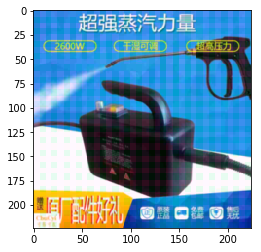

In [4]:
plt.imshow(noise_img)